# Experiment 4B (Chapter 4)

This notebook covers the code to generate Figure 4.15 and 4.17 in Chapter 4 of the textbook "Fundamentals of Active Inference".

==========================================================================
* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

*This Jupyter notebook should only be distributed to members of the "Fundamentals of Active Inference" reading group hosted by the Active Inference Institute.*

Package versions:
* matplotlib==3.5.3
* numpy==1.21.5
* pyro-ppl==1.8.4
* pytorch==1.13.1

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch

from pyro.distributions import Normal, Gamma, MultivariateNormal
from scipy.special import psi, gamma

plt.rcParams.update({
    "figure.dpi": 120})

mpl.style.use("seaborn-deep")

In the Gaussian fixed-form version of variational inference, we specify that the form of q(vartheta) is Gaussian in advance. With this assumption and further simplifications that the nonlinear function is locally linear, we can approximate VFE using a first-order taylor expansion. Then we can find the mean of the variational density with gradient descent. In the code below, we also assume that the variance of the variational density is known in advance. This simplification well make the computations more straightforward and match some of the assumptions that we will explore in Chapters 5 and 6.

To demonstrate these principles, consider a simple environment in which $x$ generates $y$ through a nonlinear function $g_{\mathcal{E}}(x)$ and both $x$ and $y$ are noisy. The environment is

$$
\mathcal{E} = \begin{cases}
    p(x) = \mathcal{N}(x; x^*, \sigma^2_x) & \text{True state} \\
    p(x \mid y) = \mathcal{N}(y; g_\mathcal{E}(x), \sigma^2_y) & \text{Observation} \\
    x^* = 4, \sigma^2_x = 0.5, \sigma^2_y = 0.5 & \text{Fixed parameters} \\
    g_{\mathcal{E}}(x) = \exp \left ( \frac{x^2 -4}{8} \right ) & \text{Nonlinear generating function}
\end{cases}
$$

As we can see, we are using a nonlinear generating function which necessitates the usage of an approximate posterior since we cannot solve Bayes' theorem exactly. According to this environment, the true hidden state is $x^*=4$. Below we define the environment and plot it.

In [2]:
n        = 50
x_range  = torch.linspace(0, 5, 500)
x_true   = 4

def g_e(x):
    return torch.exp((x**2 - 4) / 8)

def env(x_true, n):
    
    torch.manual_seed(3432)
    # Define x generation components and generate
    x    = x_true + Normal(loc=0, scale=0.5).sample([n])

    # Define y generation components
    y    = g_e(x) + Normal(loc=0, scale=0.5).sample([n])
    
    return x, y

x, y     = env(x_true, n)

<Figure size 720x480 with 0 Axes>

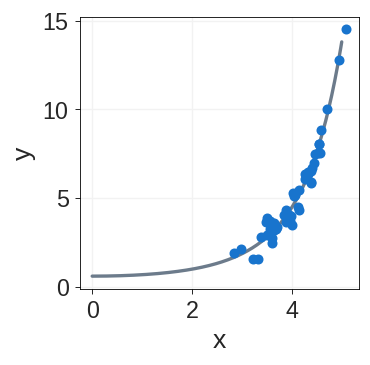

In [3]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, ax = plt.subplots(1, 1, facecolor=(1,1,1), figsize=(3,3))

ax.plot(x_range, g_e(x_range), c="#6C7B8B", lw=2)
ax.scatter(x, y, c="#1874CD", zorder=8, s=25)
ax.set_xlabel("x", fontsize=16)
ax.set_ylabel("y", fontsize=16)
# ax.text(0, 12.5, r"$ y = \exp \left ( \frac{x^2 -4}{8} \right )$", fontsize=20)

ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

Next we define the agent. The agent has the same setup as the generative process.

$$
\mathcal{M} = \begin{cases}
    p(x) = \mathcal{N}(x; \mu_x, \sigma^2_x) & \text{State belief} \\
    p(x \mid y) = \mathcal{N}(y; g_\mathcal{M}(x), \sigma^2_y) & \text{Observation mapping belief} \\
    q(x) = \mathcal{N}(x; m_x^q, {\sigma^2_x}^q) & \text{Posterior belief} \\
    \mu_x = 2, \sigma^2_x = 0.5, \sigma^2_y = 0.5, {\sigma^2_x}^q = 0.25 & \text{Fixed parameters} \\
    g_{\mathcal{M}}(x) = \exp \left ( \frac{x^2 -4}{8} \right ) & \text{Nonlinear generating function}
\end{cases}
$$

Note that here we have also defined $q(x)$. Furthermore, we have a prior on $x$ whose mean is $\mu_x$. This is the initialization of our belief about $x$ that will be updated as we see the data. The agent will need to represent the nonlinear generating function, and, as we will see below, the derivative of this function when performing gradient descent.

In [4]:
def g_m(x):
    return torch.exp((x**2 - 4) / 8)

def dg_gm(x):
    return (torch.exp(0.125 * (x**2-4)) * x) / 4

Now we can define the initializations for the agent and set up the simulation. Below we set the prior mean, the known variances on $x$ and $y$.

In [7]:
""" Agent """
iterations  = 100

# Initialize all empty arrays to be filled during simulation
m_x         = torch.zeros(iterations+1)
vfe         = torch.zeros(iterations+1)
kld         = torch.zeros(iterations+1)

# Initialze prior mean and variances on x and y
mu_x        = torch.tensor(2.)
var_y       = 0.5
var_x       = 0.5
s_x         = 0.25

# Initialize prior mean and fixed variance of q(x)
m_x[0]      = mu_x

Even though we won't use the prior distributions in our calculations, it will be helpful to calculate it, alongside the true posterior, so we can compare the two at the end of the simulation and visualize.

In [8]:
prior      = torch.exp(Normal(loc=mu_x, scale=var_x).log_prob(x_range))
true_dist  = torch.exp(Normal(loc=x_true, scale=0.25).log_prob(x_range))

According to some of the simplifications we made in this problem, variational free energy can be calculated as:

$$
\mathcal{F}(m_x^q) = \frac{1}{2} \left (\frac{(y - g_{\mathcal{M}}(m_x^q))^2}{\sigma^2_y} + \frac{(m_x^q - \mu_x)^2}{\sigma^2_x} \right )
$$

Below, we create a function for VFE according to this equation. The variables `e_y` and `e_x` are actually prediction errors which we investigate in Chapter 5. 

Another useful function is the KL-divergence between the prior and true posterior. See the code notebook `4__kl_divergence.ipynb` for more information on this function.

In [9]:
def F(
    m_x: float, 
    y: float, 
    var_y: float, 
    var_x: float, 
    mu_x: float) -> float:
    
    """ Calculate variational free energy
    
    m_x   [float] : Mean of q(x) at iteration (j)
    y     [float] : Data mean
    var_y [float] : Variance of p(y | x)
    var_x [float] : Variance of p(x)
    mu_x  [float] : Mean of p(x) (initial belief of q at iteration (j=0))

    Returns:
        float: Variational free energy at iteration (j)
    """
    
    e_y = (y - dg_gm(m_x))**2 / var_y
    e_x = (m_x - mu_x)**2 / var_x
    return -0.5 * (e_y + e_x)

def kl_divergence(p_a: torch.tensor, p_b: torch.tensor, stable: bool=True):
    
    # Stabilize zero values so they don't go to inf when taking log
    if stable:
        eps = 1e-8
        p_a[p_a == 0] = eps
        p_b[p_b == 0] = eps
    
    # Compute KL divergence
    return torch.sum(p_a * (torch.log(p_a) - torch.log(p_b)))

Using the function `F()` we can now calculate the initial VFE based on the initial values of the parameters of the variational density. We also calculate the KLD divergence.

In [10]:
vfe[0] = -F(m_x[0], torch.mean(y), var_y, var_x, mu_x)
kld[0] = kl_divergence(prior, true_dist)

The gradient descent update rule for $m_x^q$ is:

$$
{m_x^q}^{(j+1)} \leftarrow {m_x^q}^{(j)} - \kappa \frac{\partial \mathcal{F}}{\partial m_x^q}
$$

To perform this update we are going to need the derivative of VFE with respect to $m_x^q$ to perform gradient descent:

$$
\frac{\partial \mathcal{F}}{\partial m_x^q} = \frac{y - g_{\mathcal{M}}(m_x^q)}{\sigma^2_y} g'_{\mathcal{M}}(m_x^q) + \frac{m_x^q - \mu_x}{\sigma^2_x}
$$

We have everything else we need to compute this gradient. The function for the derivative of VFE with respect to $m_x^q$ is shown below.

In [11]:
def df_dmu(
    y: float, 
    m_x: float, 
    mu_x: float, 
    var_x: float, 
    var_y: float) -> float:
    
    """ Calculate the deriavtive of VFE with respect to m_x at iteration (j)
    
    y     [float] : Data mean
    m_x   [float] : Mean of q(x) at iteration (j)
    mu_x  [float] : Mean of p(x) (initial belief of q at iteration (j=0))
    var_x [float] : Variance of p(x)
    var_y [float] : Variance of p(y | x)
    
    Returns:
        float: Deriavtive of VFE with respect to m_x at iteration (j)
    """
    
    e_y = (y - g_m(m_x)) / var_y
    e_x = (m_x - mu_x) / var_x
    return e_y * dg_gm(m_x) - e_x

The update is shown below along with the VFE update at the end of the iteration. We use a learning rate of $\kappa=0.009$. We also calculate the KL divergence for each of the iteration updates using the current estimate for $q(x)$ given the model parameters we have just updated.

In [16]:
kappa            = 0.009

for j in range(iterations):
    # Update m_x and VFE
    m_x[j+1]     = m_x[j] + kappa * df_dmu(torch.mean(y), m_x[j], mu_x, var_x, var_y)
    vfe[j+1]     = -F(m_x[j], torch.mean(y), var_y, var_x, mu_x)
    
    # Calculate the current estimate of the posterior and the KL divergence 
    post_update  = torch.exp(Normal(loc=m_x[j+1], scale=s_x).log_prob(x_range))
    kld[j+1]     = kl_divergence(post_update, true_dist)
    
final_post       = torch.exp(Normal(loc=m_x[-1], scale=s_x).log_prob(x_range))

The results are shown below.

<Figure size 720x480 with 0 Axes>

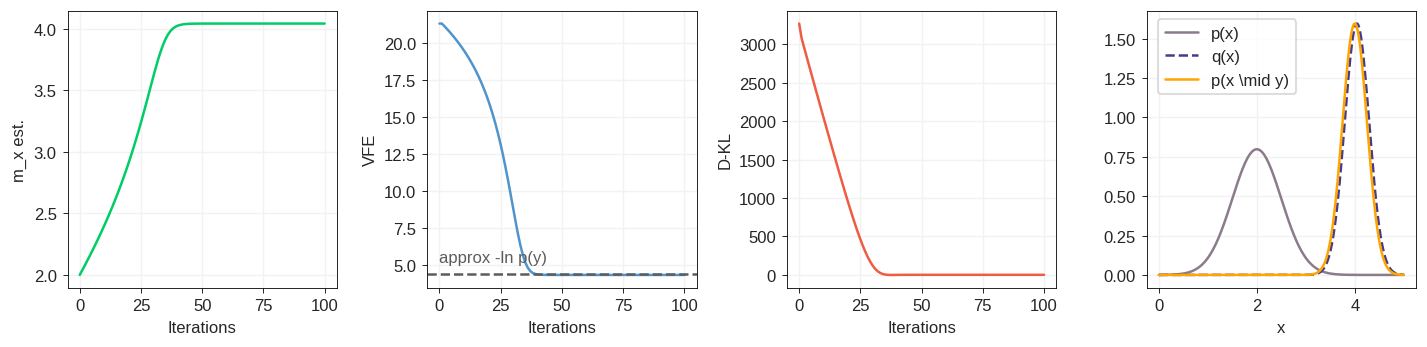

In [20]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1, 4, facecolor=(1,1,1), figsize=(12,3))

surp = -F(torch.tensor(4.), torch.mean(y), 0.5, 0.5, 2)

axes[0].plot(range(iterations+1), m_x, c="#00CD66")
axes[1].plot(range(iterations+1), vfe, c="#4F94CD")
axes[1].axhline(surp, 0, c="#5C5C5C", ls="--")
axes[1].text(0, 5.2, "approx -ln p(y)", c="#5C5C5C", fontsize=10)
axes[2].plot(range(iterations+1), kld, c="#EE5C42")
axes[3].plot(x_range, prior, label="p(x)", c="#8B7B8B")
axes[3].plot(x_range, final_post, label="q(x)", c="#473C8B", ls="--")
axes[3].plot(x_range, true_dist, label="p(x \mid y)", c="#FFA500")

# Set labels
axes[0].set_xlabel("Iterations")
axes[0].set_ylabel("m_x est.")
axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("VFE")
axes[2].set_xlabel("Iterations")
axes[2].set_ylabel("D-KL")
axes[3].set_xlabel("x")

# Cosmetic changes and axes ranges
for ax in axes:
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.legend(loc="upper right", bbox_to_anchor=(0.91, 0.95), frameon=True)
fig.tight_layout()